In [2]:
library(Seurat)
library(dplyr)
library(tximport)
library(ggplot2)
library(ggsci)
library(ggalluvial)
library(alluvial)
library(tidyverse)
library(pheatmap)
library(RColorBrewer)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.3     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Processing *A. thaliana* data

In [4]:
files <- file.path("/data/Matthew/scrna/sc_align/ath_salmon_leaf/alevin/quants_mat.gz")
txi <- tximport(files, type = "alevin")
ath_obj <- CreateSeuratObject(counts = txi$counts, project = "Ath_Leaf", min.cells = 3)

id_path <- "/data/Matthew/scrna/02.Clustering/id_archive_Apr21/"
s.genes <- readLines(paste(id_path, "ath_cellcycle.s.id",sep = "/"))
g2m.genes <- readLines(paste(id_path, "ath_cellcycle.g2m.id",sep = "/"))

ath_obj[["percent.mt"]] <- PercentageFeatureSet(ath_obj, pattern = "^ATMG")
ath_obj[["percent.chl"]] <- PercentageFeatureSet(ath_obj, pattern = "^ATCG")

ath_obj <- subset(
  ath_obj,
  subset =
    nFeature_RNA > 500 &
    nFeature_RNA < 10000 &
    nCount_RNA < 50000 &
    nCount_RNA > 500 &
    percent.mt < 5 &
    percent.chl < 10
)
ath_obj <-
  CellCycleScoring(
    ath_obj,
    s.features = s.genes,
    g2m.features = g2m.genes,
    set.ident = TRUE
  )
ath_obj$CC.Difference <-
  ath_obj$S.Score - ath_obj$G2M.Score

ath_obj <- ath_obj %>%
    NormalizeData() %>%
    FindVariableFeatures() %>%
    ScaleData(vars.to.regress = c("CC.Difference"), verbose = F) %>%
    RunPCA(verbose = F) %>%
    RunTSNE(dims = 1:50) %>%
    RunUMAP(dims = 1:50, verbose = F) %>%
    FindNeighbors(dims = 1:50, verbose = F) %>%
    FindClusters(resolution = 0.5, verbose = F) %>%
    identity()

reading in alevin gene-level counts across cells with fishpond

Warning message:
“The following features are not present in the object: AT3G59765, AT1G78865, AT1G04425, AT4G12870, not searching for symbol synonyms”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


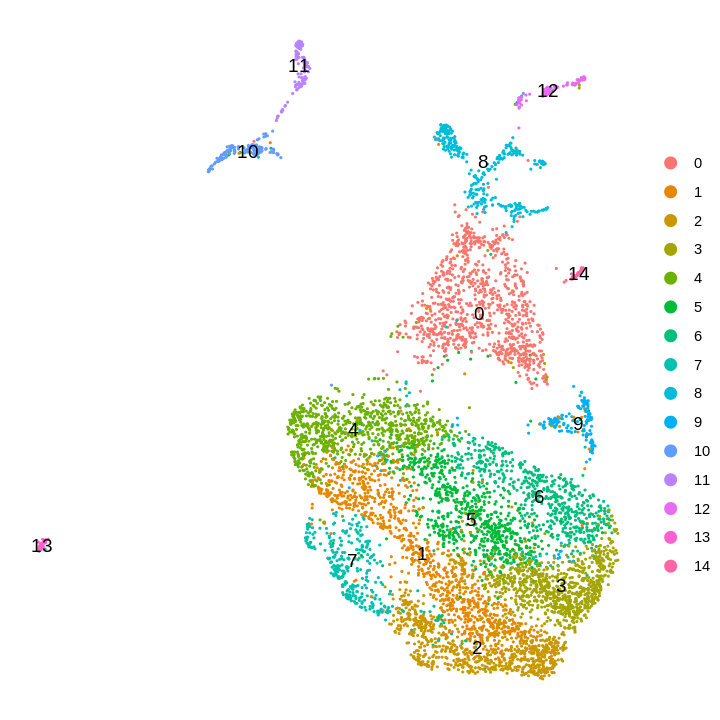

In [5]:
options(repr.plot.height = 6, repr.plot.width = 6)
p_numcluster <-
  DimPlot(object = ath_obj, reduction = "umap", label = T) +
  theme_void()
p_numcluster

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: AT4G30140, AT1G62360, AT4G08150, AT1G13710”


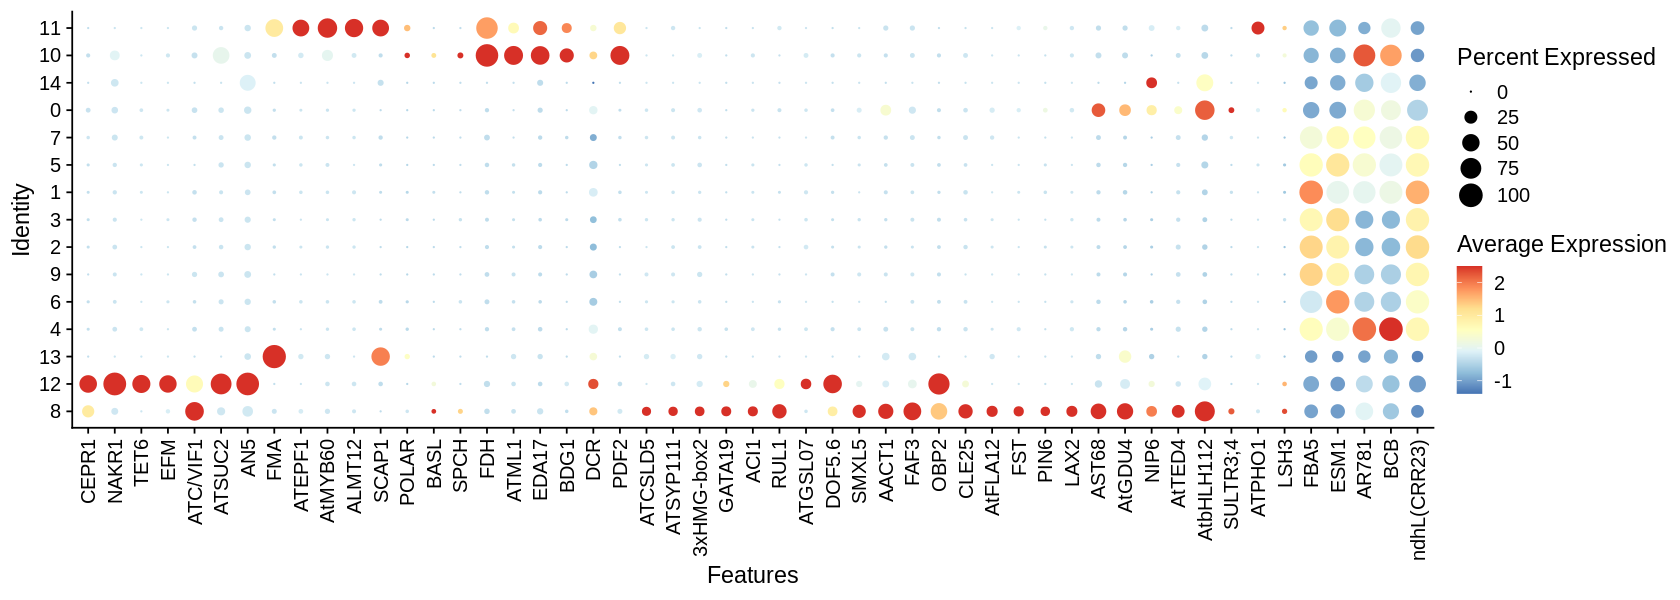

In [6]:
options(repr.plot.height = 5, repr.plot.width = 14)

celltype <- readLines(paste(id_path, "ath_celltype.id", sep = "/"))
celltype_name <- readLines(paste(id_path, "ath_celltype_leaf.name", sep = "/"))
DotPlot(ath_obj, features = celltype, cluster.idents = T, cols = "RdYlBu", scale.by = "size") +
  scale_x_discrete(labels = celltype_name) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
ggsave('leafcmp_celltype.pdf', width = 14, height = 5)

In [7]:
# Alevin leaf
new_cluster_ids <- c("ath_VC", "ath_MC", "ath_MC", "ath_MC", "ath_MC",
                     "ath_MC", "ath_MC", "ath_MC", "ath_VC", "ath_MC",
                     "ath_EC", "ath_GC", "ath_CC", "ath_GC", "ath_VC")

# Add seurat object levels to new_cluster_ids
names(new_cluster_ids) <- levels(ath_obj)
# Rename clusters
ath_obj <- RenameIdents(ath_obj, new_cluster_ids)
ath_obj[["old.ident"]] <- Idents(object = ath_obj)

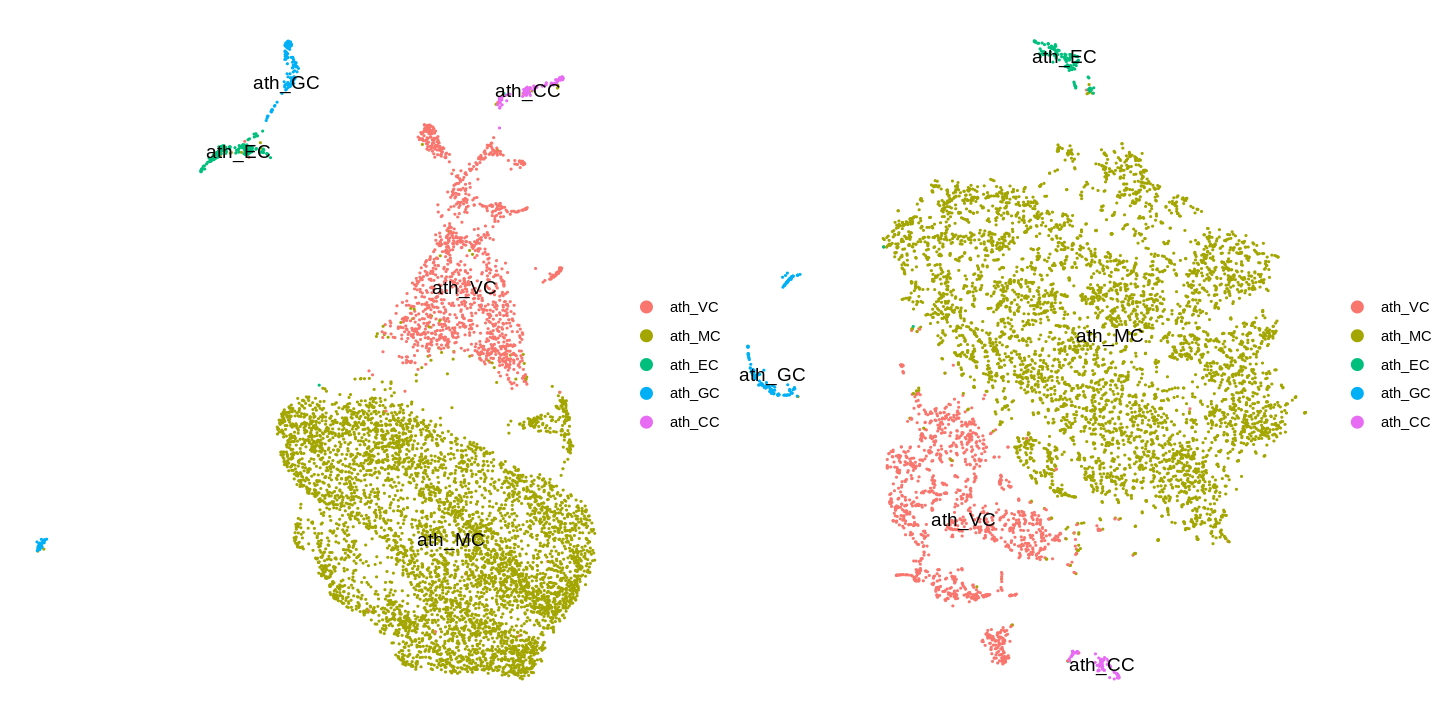

In [8]:
# t-SNE plot
options(repr.plot.height = 6, repr.plot.width = 12)
p_renamecluster_umap <- DimPlot(ath_obj, reduction = "umap", label = TRUE) +
  theme_void()
p_renamecluster_tsne <- DimPlot(ath_obj, reduction = "tsne", label = TRUE) +
  theme_void()
p_renamecluster_umap + p_renamecluster_tsne

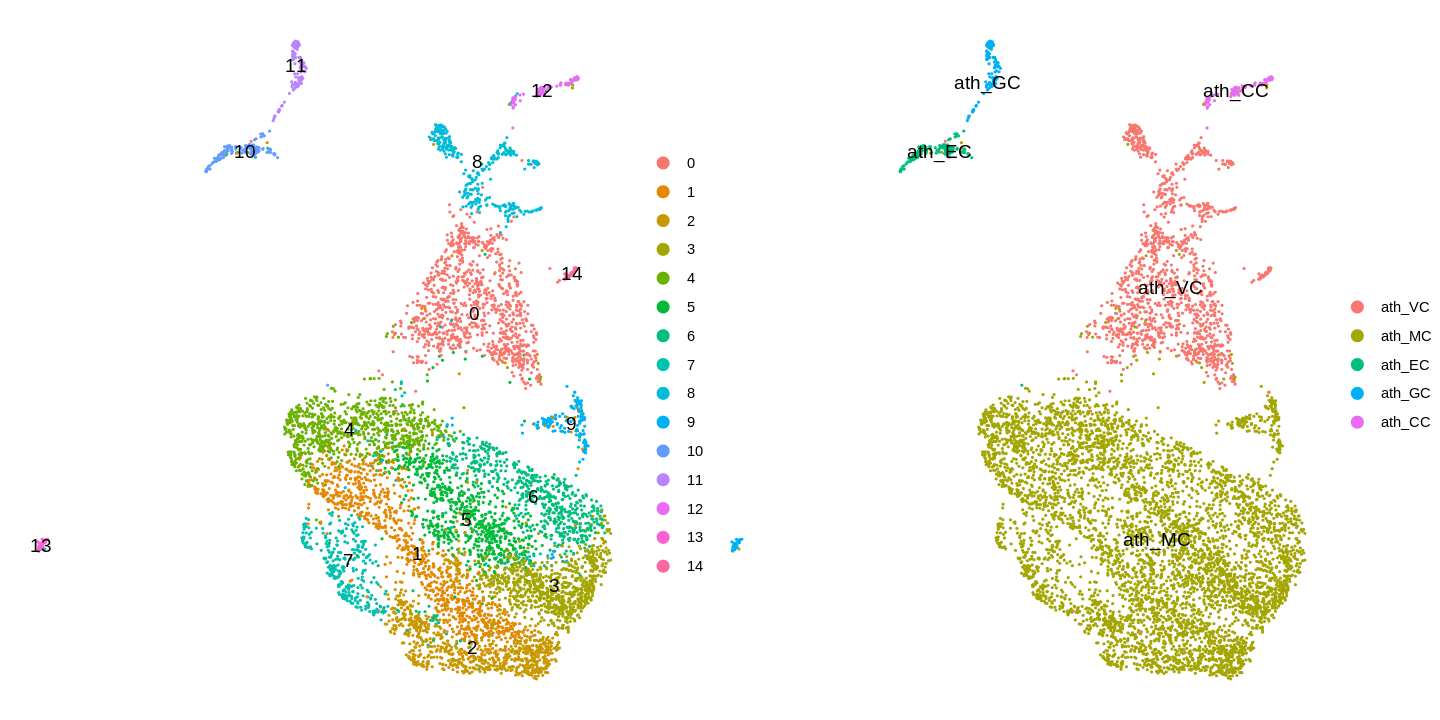

In [9]:
p_numcluster + p_renamecluster_umap
ggsave("leafcmp_umap.png", width = 10, height = 5, dpi = 300)

# Load *C. roseus* data

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3005
Number of edges: 99853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8354
Number of communities: 6
Elapsed time: 0 seconds


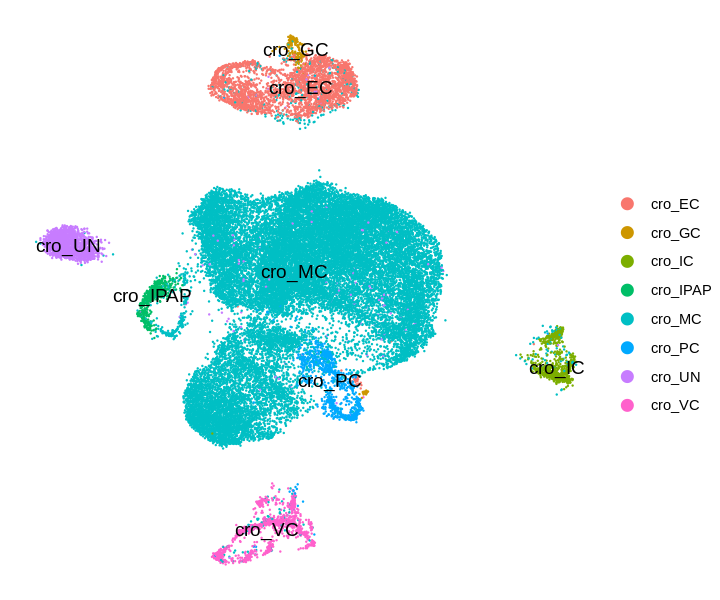

In [15]:
options(repr.plot.height = 5, repr.plot.width = 6)
load(file = "/data/Matthew/scrna/02.Clustering/crov7_alv_mincell5.Rdata")
# new cluster names
new.cluster.ids <- c("MC", "MC", "MC", "MC", "MC",
                     "MC", "EC", "UN", "VC", "EC",
                     "PC", "IC", "IPAP", "MC")

# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)
seurat_obj[["old.ident"]] <- Idents(object = seurat_obj)

# find sub clusters
for (i in c("EC")) {
  seurat_obj <- FindSubCluster(seurat_obj, cluster = i,
                               graph.name = "RNA_snn",
                               resolution = 0.4,
                               algorithm = 1)
  sub_name <- as.factor(seurat_obj@meta.data$sub.cluster)
  names(sub_name) <- names(seurat_obj@active.ident)
  seurat_obj@active.ident <- sub_name
}
# add name to clusters
seurat_obj[["seurat_clusters"]] <- seurat_obj@active.ident
# new cluster names
new.cluster.ids <- paste("cro_",
    c("EC", "EC", "EC", "EC", "EC", "GC",
      "IC", "IPAP", "MC", "PC", "UN", "VC"), sep = "")
# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)

DimPlot(seurat_obj, reduction = "umap", label = TRUE) + theme_void()

In [19]:
ath_exp <- AverageExpression(ath_obj)
cro_exp <- AverageExpression(seurat_obj)

ath_index <- ath_exp$RNA %>% 
  as.data.frame() %>% 
  rownames_to_column(var = "ath_id") %>% 
  as_tibble() %>% 
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(ath_VC:ath_CC)) / 5,
    MC_ath = ath_MC / mean_gC,
    EC_ath = ath_EC / mean_gC,
    GC_ath = ath_GC / mean_gC,
    VC_ath = ath_VC / mean_gC,
    CC_ath = ath_CC / mean_gC,
  ) %>%
  select(ath_id, MC_ath:CC_ath) %>% 
  identity()

cro_index <- cro_exp$RNA %>%
  as.data.frame() %>% 
  rownames_to_column(var = "cro_id") %>% 
  as_tibble() %>% 
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(cro_EC:cro_VC)) / 8,
    MC_cro = cro_MC / mean_gC,
    UN_cro = cro_UN / mean_gC,
    PC_cro = cro_PC / mean_gC,
    IPAP_cro = cro_IPAP / mean_gC,
    IC_cro = cro_IC / mean_gC,
    EC_cro = cro_EC / mean_gC,
    VC_cro = cro_VC / mean_gC,
    GC_cro = cro_GC / mean_gC
  ) %>%
  select(cro_id, MC_cro:GC_cro) %>% 
  identity()

In [20]:
head(cro_index)

cro_id,MC_cro,UN_cro,PC_cro,IPAP_cro,IC_cro,EC_cro,VC_cro,GC_cro
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EVM0032325,0.7233394,2.0460093,0.5234269,0.9685501,0.22118376,1.107042,0.9153737,1.4950753
EVM0015844,0.5444073,1.0631637,0.2975833,1.0591179,0.00318724,2.373298,1.9962999,0.6629429
EVM0031208,0.6703584,0.2568952,0.1560066,2.3686686,0.00000000,1.363727,0.0000000,3.1843442
EVM0000976,0.9367290,0.2519521,0.8434863,0.7799890,1.24140100,1.294657,1.0194200,1.6323655
EVM0034578,1.1184842,0.3956646,0.8249599,0.7988576,0.93426043,1.211669,1.3166262,1.3994786
EVM0033217,1.1106255,0.2666216,0.2736164,1.1048073,0.79216738,1.073398,1.7709624,1.6078015


In [22]:
rbh <- read.table(paste(id_path, 'cro_ath.tsv',sep = '/'), col.names = c("cro_id", "ath_id")) %>% as_tibble()

cro_sub_index <- left_join(rbh, cro_index)
ath_sub_index <- left_join(rbh, ath_index)

cor_spearman <-
  left_join(cro_sub_index, ath_sub_index) %>% 
  select(-c("cro_id","ath_id")) %>%
  drop_na() %>%
  cor(method = 'spearman') %>%
  identity()

cor_spearman

Joining, by = "cro_id"

Joining, by = "ath_id"

Joining, by = c("cro_id", "ath_id")



,MC_cro,UN_cro,PC_cro,IPAP_cro,IC_cro,EC_cro,VC_cro,GC_cro,MC_ath,EC_ath,GC_ath,VC_ath,CC_ath
MC_cro,1.000000000,0.615722373,0.006913378,0.45555552,0.292311347,-0.03168430,-3.790227e-01,-0.33245641,0.33842568,-5.232342e-02,-0.009834107,0.009997255,-0.019687963
UN_cro,0.615722373,1.000000000,-0.042566155,0.36602795,0.266533711,-0.07011735,-3.293633e-01,-0.26378083,0.30790803,-5.898265e-02,0.007956472,-0.004647036,-0.007121678
PC_cro,0.006913378,-0.042566155,1.000000000,0.01460005,-0.052727858,-0.26728677,-3.208501e-02,-0.16070246,0.18051483,-5.031054e-02,-0.091705647,0.136247040,0.119422509
IPAP_cro,0.455555523,0.366027949,0.014600047,1.00000000,0.216929733,-0.18962200,-2.069036e-01,-0.22726069,0.27955917,-5.797020e-02,0.016211600,0.052873272,0.058991176
IC_cro,0.292311347,0.266533711,-0.052727858,0.21692973,1.000000000,-0.14974287,-1.709225e-01,-0.28914711,0.30517720,-2.042588e-02,0.052396618,0.024884020,0.006498507
EC_cro,-0.031684304,-0.070117353,-0.267286769,-0.18962200,-0.149742866,1.00000000,-9.491855e-02,0.29132395,-0.19274616,3.217202e-01,0.146586067,-0.134809427,-0.110211430
VC_cro,-0.379022655,-0.329363285,-0.032085009,-0.20690361,-0.170922454,-0.09491855,1.000000e+00,-0.01889236,-0.20439049,-4.068962e-05,0.030048161,0.016338201,0.271715315
GC_cro,-0.332456407,-0.263780827,-0.160702457,-0.22726069,-0.289147114,0.29132395,-1.889236e-02,1.00000000,-0.16741946,2.246170e-01,0.224005970,-0.110798977,-0.026504227
MC_ath,0.338425677,0.307908032,0.180514829,0.27955917,0.305177196,-0.19274616,-2.043905e-01,-0.16741946,1.00000000,-5.217998e-02,-0.146507152,0.247821196,-0.106837025
EC_ath,-0.052323421,-0.058982646,-0.050310542,-0.05797020,-0.020425880,0.32172018,-4.068962e-05,0.22461697,-0.05217998,1.000000e+00,0.042210939,-0.171201101,-0.257438195


In [23]:
pheatmap(cor_spearman[9:13,1:8],
         display_numbers = T,
#          fontsize = 14,
         cluster_cols = F,
         cluster_rows = F,
        cellwidth = 40,
        cellheight = 40,
        angle_col = 0,
        filename = "leafcmp.heatmap.pdf")
#          treeheight_row = 0,
#          treeheight_col = 0)

In [24]:
rbh <- read.table(paste(id_path, "cro_ath.tsv", sep = "/"))
cro_obj <- subset(seurat_obj, features = rbh$V1)
cro_count_mat <- GetAssayData(cro_obj, slot = "count")

cro_count_mat@Dimnames[[1]] <- filter(rbh, V1 %in% rownames(cro_obj))$V2

cro_trans_id_obj <- 
    CreateSeuratObject(counts = cro_count_mat, project = "C.roseus")

cro_trans_id_obj[["old.ident"]] <- FetchData(cro_obj, var = "ident")

ath_sub_obj <- subset(ath_obj, features = rbh$V2)

In [25]:
obj.merge <- merge(ath_sub_obj, y = cro_trans_id_obj, 
                   add.cell.ids = c("ath", "cro"), project = "ath_cro")

obj.list <- SplitObject(obj.merge, split.by = "orig.ident")

obj.list

$Ath_Leaf
An object of class Seurat 
11106 features across 6861 samples within 1 assay 
Active assay: RNA (11106 features, 0 variable features)

$cro1
An object of class Seurat 
11106 features across 8510 samples within 1 assay 
Active assay: RNA (11106 features, 0 variable features)

$cro2
An object of class Seurat 
11106 features across 15813 samples within 1 assay 
Active assay: RNA (11106 features, 0 variable features)

$cro3
An object of class Seurat 
11106 features across 10069 samples within 1 assay 
Active assay: RNA (11106 features, 0 variable features)


In [26]:
obj.list <- lapply(X = obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})
features <- SelectIntegrationFeatures(object.list = obj.list)
obj.anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = features)
# this command creates an "integrated" data assay
obj.combined <- IntegrateData(anchorset = obj.anchors)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 19716 anchors

Filtering anchors

	Retained 1524 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23131 anchors

Filtering anchors

	Retained 1612 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 25698 anchors

Filtering anchors

	Retained 6217 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21152 anchors

Filtering anchors

	Retained 1516 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21844 anchors

Filtering anchors

	Retained 6492 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 26305 anchors

Filtering anchors

	Retained 12902 anchors

Merging dataset 4 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector

In [27]:
# specify that we will perform downstream analysis on the corrected data note that the original
# unmodified data still resides in the "RNA" assay
DefaultAssay(obj.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
obj.combined <- obj.combined %>%
    ScaleData(verbose = FALSE) %>%
    RunPCA(npcs = 50, verbose = FALSE) %>%
    RunTSNE(reduction = "pca", dims = 1:50) %>%
    RunUMAP(reduction = "pca", dims = 1:50, verbose = FALSE) %>%
    FindNeighbors(reduction = "pca", dims = 1:50, verbose = FALSE) %>%
    FindClusters(resolution = 0.5, verbose = FALSE) %>%
    identity()

In [37]:
save(obj.combined, file = '/data/Matthew/scrna/02.Clustering/cro_cmb_leaf_compare.Rdata')

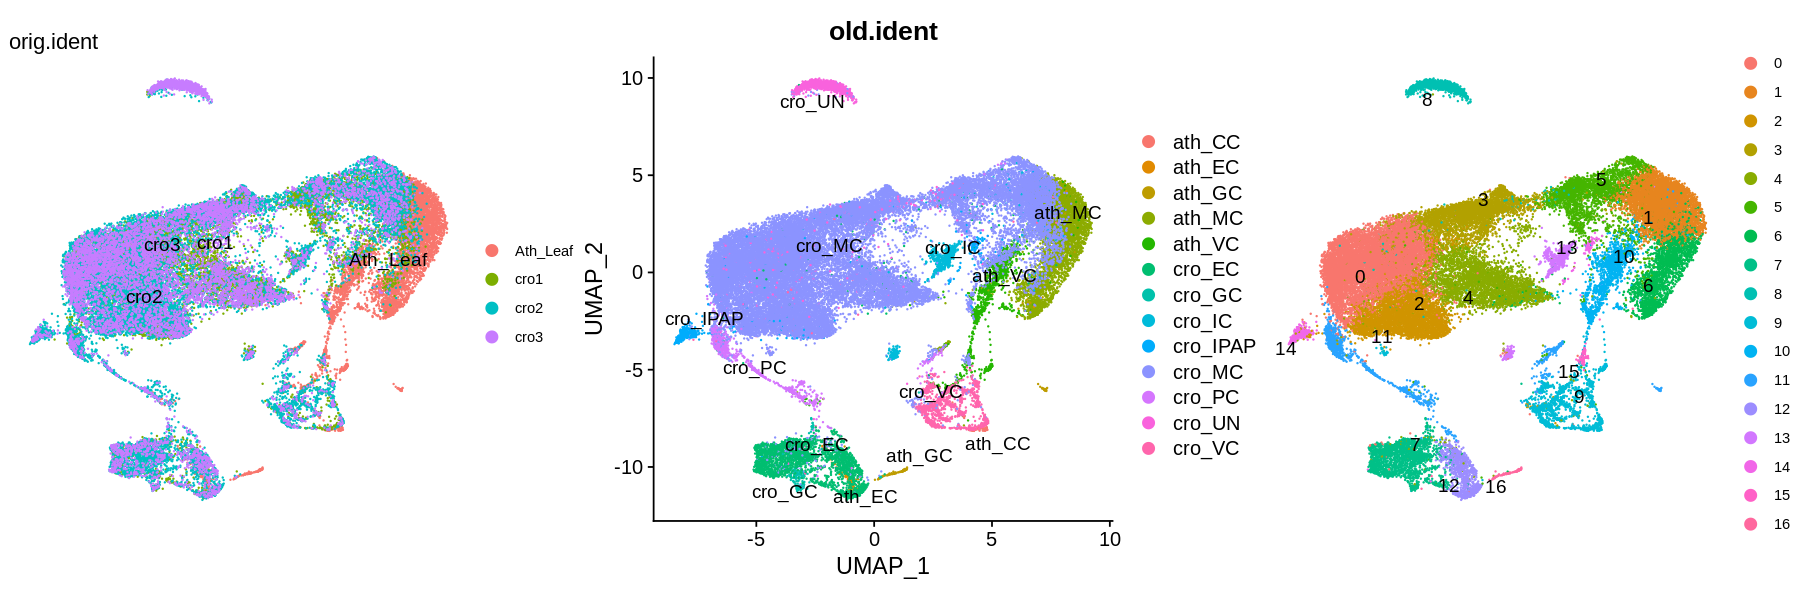

In [28]:
options(repr.plot.height = 5, repr.plot.width = 15)
# Visualization
p1 <- DimPlot(obj.combined, reduction = "umap", group.by = "orig.ident", label = TRUE, repel = TRUE)+ theme_void()
p2 <- DimPlot(obj.combined, reduction = "umap", group.by = "old.ident", label = TRUE, repel = TRUE)
p3 <- DimPlot(obj.combined, reduction = "umap", label = TRUE, repel = TRUE)+ theme_void()
p1 + p2 + p3
# ggsave(filename = "ath_leaf_cro_umap.pdf", width = 15, height = 5)

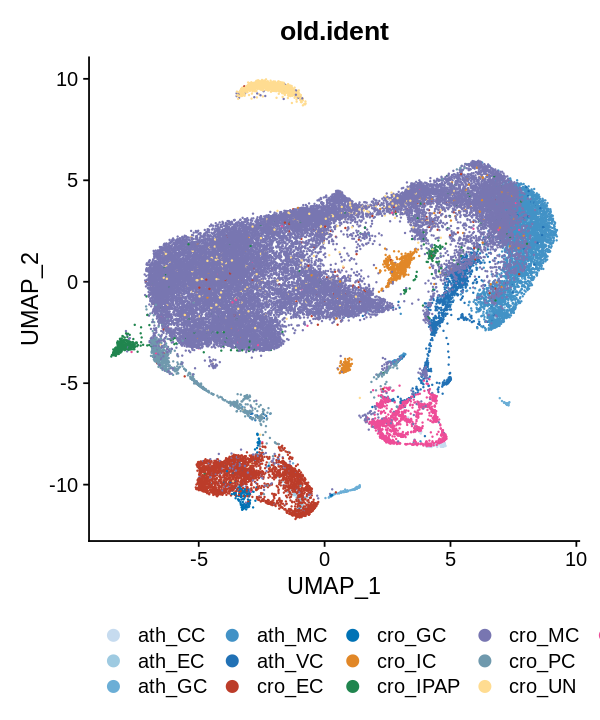

In [39]:
options(repr.plot.height = 6, repr.plot.width = 5)
palath <- brewer.pal(9, "Blues")
palcro <- pal_nejm()(8)


DimPlot(obj.combined, reduction = "umap", group.by = "old.ident", 
        label = F, repel = TRUE, cols = c(palath[3:7], palcro)) + theme(legend.position="bottom")

In [40]:
# ggsave("leafcmp_umpa.png", dpi = 600, width = 6, height = 5)
ggsave("leafcmp_umpa.pdf", width = 5, height = 6)

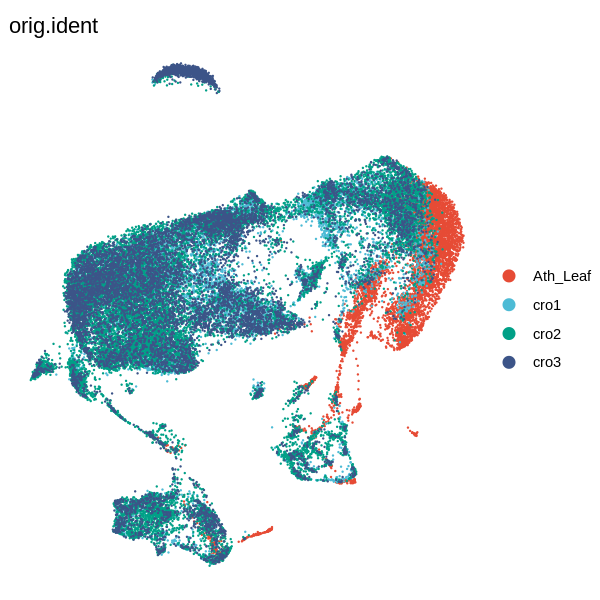

In [35]:
options(repr.plot.height = 5, repr.plot.width = 5)
DimPlot(obj.combined, reduction = "umap", group.by = "orig.ident",
        label = F, repel = TRUE) + theme_void() + scale_color_npg()

In [36]:
ggsave("leafcmp_ump_orig.png", dpi = 600, width = 6, height = 5)

In [21]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/Matthew/miniconda3/envs/psdtime/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] alluvial_0.1-2     ggalluvial_0.12.3  ggsci_2.9          ggplot2_3.3.5     
[5] tximport_1.18.0    dplyr_1.0.7        SeuratObject_4.0.2 Seurat_4.0.3      

loaded via a namespace (and not attached):
  [1] uuid_0.1-4                  sn_2.0.0                   
  [3] plyr_1.8.6                 